In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
print(stoi)
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [16]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [16]:
C=torch.randn((27,2))

In [19]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [20]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [27]:
h = torch.tanh(emb.view(emb.shape[0],6) @ W1 + b1)
h

tensor([[-0.2612, -0.4473,  0.7229,  ..., -0.0487, -0.2007,  0.9748],
        [-0.2136,  0.3319, -0.3941,  ..., -0.8598,  0.6223,  0.9241],
        [ 0.4517, -0.3217, -0.1097,  ..., -0.6611, -0.0132,  0.4852],
        ...,
        [-0.2309, -0.7802,  0.6692,  ..., -0.2964,  0.8582,  0.9871],
        [-0.6138,  0.8741,  0.7461,  ..., -0.6459, -0.5451,  0.9002],
        [ 0.2325, -0.9141,  0.1664,  ...,  0.2368, -0.7335,  0.9813]])

In [28]:
h.shape

torch.Size([32, 100])

In [29]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [30]:
logits = h @ W2 + b2

In [31]:
logits.shape

torch.Size([32, 27])

In [32]:
counts = logits.exp()

In [49]:
prob = counts / counts.sum(1, keepdims=True)
print(prob.shape)


torch.Size([32, 27])


In [37]:
prob[0].sum() #every row of prob is normalized 

tensor(1.0000)

In [53]:
#calculate the loss 
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(12.4190)

In [54]:
log_probs = F.log_softmax(logits, dim=1)  # numerically stable log-softmax
loss = -log_probs[torch.arange(32), Y].mean()
loss

tensor(17.7697)

In [42]:
# ------------ clean collective code :) ---------------

In [17]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [18]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [19]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [20]:
for p in parameters:
  p.requires_grad = True

In [21]:
#how to choose an optimal learning rate
lre = torch.linspace(-3, 0, 1000) #lre = learning rate exponent
lrs = 10**lre #actual learning rate 

In [22]:
lri = []
lossi = []
stepi = []

In [34]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

2.1043715476989746


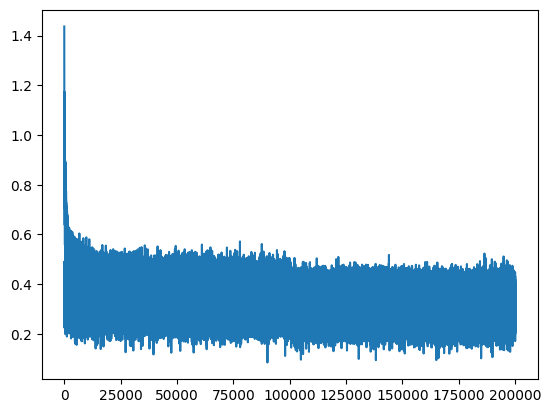

In [35]:
plt.plot(stepi, lossi)

In [36]:
#training dataset
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0744, grad_fn=<NllLossBackward0>)

In [37]:
#validation dataset
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1411, grad_fn=<NllLossBackward0>)

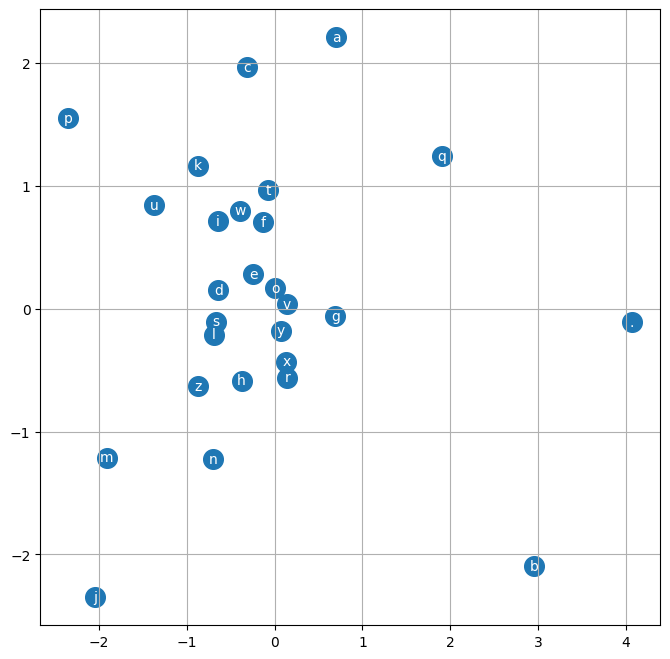

In [38]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [32]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [33]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carlah.
ambril.
khy.
mili.
taty.
salayske.
mahnen.
den.
art.
areei.
nermara.
chaiivia.
leigh.
ham.
poit.
quintzarlin.
alianni.
watelo.
dearynn.
jaxsini.
